## Series estacionarias
Una serie es considerada estacionaria si su distribución no cambia con el tiempo. El supuesto es que cada serie es generada por un Proceso Generador de Datos (PGD) que no cambia su distribución. Existe dos definiciones de estacionariedad:
### 1. Estacionariedad débil:
$y_t$ es debilmente estacionaria si sus dos primeros momentos individuales no dependen del tiempo. Se cumple las propiedades:
* $E(y_t)=\mu<\infty$ 
* $Var(y_t)=E[(y_t-\mu)^2]=\sigma^2<\infty$
* $Cov(y_t, y_{t-k}) = E[(y_t-\mu)(y_{t-k}-\mu)]=\gamma_k; \hspace{0.5cm} k>0$

donde $k$ es la separación entre observaciones. En ese sentido, la correlación entre dos periodos no depende del tiempo, sino de la distancia. Esta definición es la más usada, debido a que no es tan restrictiva.

### 2. Estacionariedad fuerte:
$y_t$ es estrictamente estacionaria si la distribución conjunta $F(y_1, y_2, ... yj)$ no depende del tiempo, para todo j. Es decir: $$F(y_1, y_2, ... yj)=F(y_{1+s}, y_{2+s}, ... y{j+s})$$
Esta definición requiere que todos los momentos sean independientes del tiempo.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import statsmodels.tsa.api as tsa
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

import warnings
warnings.simplefilter("ignore")

%run "../utils.py"

np.random.seed(19)

### ACF y PACF
La autocovarianza de un serie $y_t$ se define por $Cov(y_t, y_{t-k}) = \gamma_k$, y mide la relación entre un periodo y $k$ periodos hacia atrás.
La autocovarianza, por su parte, es la covarianza divida por las desviaciones estándar de cada serie: $$\dfrac{Cov(y_t, y_{t-k})}{Var(y_t)^{1/2}Var(y_{t-k})^{1/2}} = \rho_k$$

#### Propiedades
* $\gamma_0 = \sigma^2$
* $|\gamma_0| \leqslant \gamma_0$
* $\gamma_{-k} = \gamma_l$
* $\rho_0 = 1$
* $|\rho_0| \leqslant \rho_0$
* $\rho_{-k} = \rho_l$

#### Función de Autocorrelación (ACF)
Secuencia de autocorrelación para diferentes $k$.

Dado una serie simple definida por $y_t = \phi y_{t-1} + e_t$. La ACF sería $\rho_k = \phi^k$. De esta manera, a medida que el coeficiente $\phi$ sea mayor, el decaimiento en la ACF y la correlación con el pasado será muy lento. 

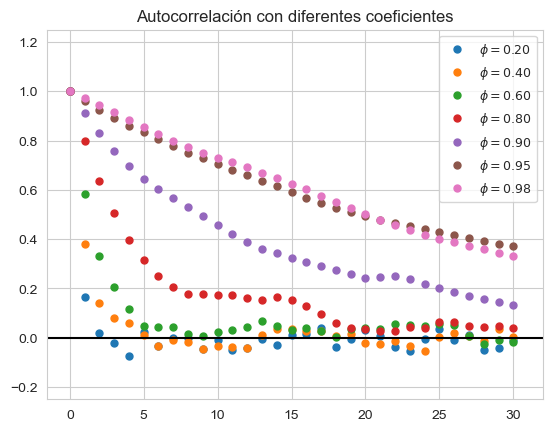

In [42]:
phi_02  = define_arma_model([0.2], [0], 1_000)
phi_04  = define_arma_model([0.4], [0], 1_000)
phi_06  = define_arma_model([0.6], [0], 1_000)
phi_08  = define_arma_model([0.8], [0], 1_000)
phi_09  = define_arma_model([0.9], [0], 1_000)
phi_095 = define_arma_model([0.95], [0], 1_000)
phi_098 = define_arma_model([0.98], [0], 1_000)

fig, ax = plt.subplots(1)

plot_acf(phi_02,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.20$", alpha=1)
plot_acf(phi_04,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.40$", alpha=1)
plot_acf(phi_06,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.60$", alpha=1)
plot_acf(phi_08,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.80$", alpha=1)
plot_acf(phi_09,  ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.90$", alpha=1)
plot_acf(phi_095, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.95$", alpha=1)
plot_acf(phi_098, ax=ax, lags=30, use_vlines=False, label=r"$\phi=0.98$", alpha=1)
plt.axhline(y=0, color="black", linestyle="-")

ax.set_ylim([-.25, 1.25])
plt.title("Autocorrelación con diferentes coeficientes")
plt.legend(fontsize=9)


plt.show()

#### Función Parcial de Autocorrelación (PACF)
Halla la autocorrlación de dos periodos sin contar la influencia de los periodos que los separan

### Procesos estacionarios
#### 1. Ruido blanco
El modelo más básico estacio es llamado ruido blanco y se define por un proceso de ruidos {$e_t$} con media cero y varianza $\sigma^2$: $$y_t = e_t, \hspace{0.5cm} e_t \sim N(0, 1)$$
donde se requiere que los errores no estén autocorrelacionados con el tiempo: $$E(e_t e_\tau)=0, \hspace{0.5cm} t\neq\tau$$

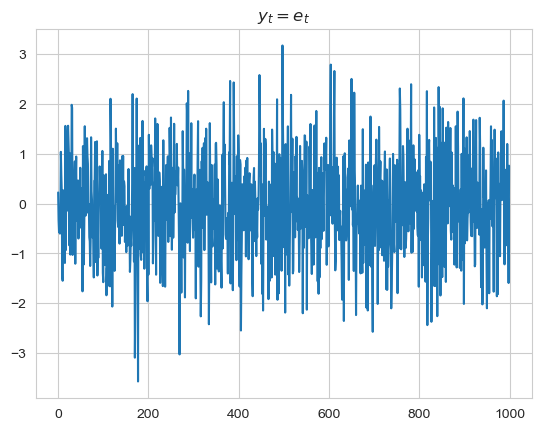

In [2]:
mu = 0
sd = 1
smpl = 1_000

nwn = np.random.normal(mu, sd, smpl)

# Serie
fig = plt.figure()
fig = plt.plot(nwn)

plt.title(r"$y_t=e_t$")
plt.show()

#### 2. MA(1)
El proceso _moving average_ de primer orden es doonde el termino de ruido blanco incluye un rezago: $$y_t = \mu + e_t + \theta e_{t-1}$$
Donde la media $\mu$ y el coeficiente $\theta$ son constante. Esta serie sí tendrá correlación hasta de un periodo

Se generarán dos series estacionarias definidas de la siguiente manera:
* AR(1): $y_t=0.2y_{t-1}+e_t$
* ARMA(2,1): $y_t=0.6y_{t-1}-0.2y_{t-2}+e_t+0.2e_{t-2}$

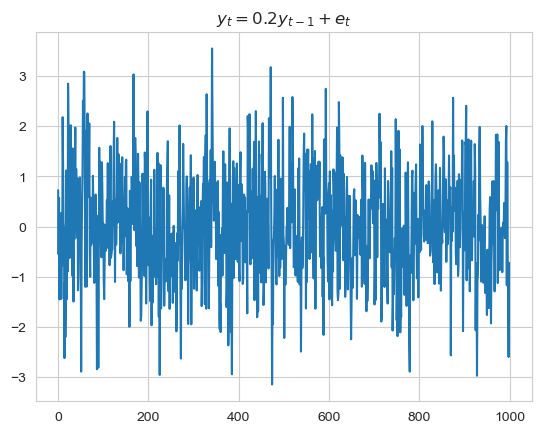

In [4]:
# Definiendo los parámetros de los componentes AR y MA
ar_p = np.array([0.2, 0])
ma_p = np.array([0])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

ar1 = arma_generate_sample(ar, ma, nsample=1000)
ar1 = pd.Series(ar1)

# Serie
fig = plt.figure()
fig = plt.plot(ar1)

plt.title(r"$y_t=0.2y_{t-1}+e_t$")
plt.show()

In [ ]:
ar_p = np.array([0.6, -0.2])
ma_p = np.array([0.2])

# Incluyo una constante. Para el caso del AR debo colocarlo en negativo
ar = np.r_[1, -ar_p]
ma = np.r_[1, ma_p]

serie2 = arma_generate_sample(ar, ma, nsample=1000)
serie2 = pd.Series(serie2)

# Serie
fig = plt.figure()
fig = plt.plot(serie2)

plt.title(r"$y_t=0.6y_{t-1}-0.2y_{t-2}+e_t+0.2e_{t-2}$")
plt.show()

### ACFm PACF
Para entender 

In [ ]:
fig, ax = plt.subplots(1, 2)

plot_acf(serie, ax=ax[0], lags=10, title="ACF", alpha=0.05)
plot_pacf(serie, ax=ax[1], lags=10, title="PACF", alpha=0.05)

ax[0].set_ylim([-.5, 1.25])
ax[1].set_ylim([-.5, 1.25])

plt.show()

In [ ]:
ar1 = tsa.arima.ARIMA(serie, order=(1,0,0))
ar1 = ar1.fit()

print(ar1.summary())

Luego, el ARMA(2,1)

In [ ]:
arma21 = tsa.arima.ARIMA(serie, order=(2,0,1))
arma21 = arma21.fit()

print(arma21.summary())

### Selección de un modelo: Criterios de informacion

In [ ]:
criterias = arma_order_select_ic(serie, max_ar=3, max_ma=3, ic=["aic", "bic"])

print(f"El mejor modelo seleccionado por AIC es {criterias.aic_min_order} y por BIC es {criterias.bic_min_order}")

Pese a que haya simulado la serie como un ARMA(2,1), los criterios de informacion me seleccionan como el mejor modelo a una MA(2)

In [ ]:
model = tsa.arima.ARIMA(serie, order=(0,0,2))
model = model.fit()

print(model.summary())

### Analisis de los residuos
Tras la estimacion de un modelo, los residuos deberian comportarse como un ruido blanco. Es decir, no deberia tener autorrelación serial

In [ ]:
resids = model.resid


fig, ax = plt.subplots(1)
plot_acf(
    resids, ax=ax, lags=10,
    title="ACF de los residuos", color="black",
    vlines_kwargs={"colors": "black"})

plt.ylim([-.5, 1.25])

plt.show()

Aunque, igual se podría graficar todos los resultados en uno

In [ ]:
fig = model.plot_diagnostics()

fig.tight_layout(pad=2)
plt.show()

Tambien se podria realizar el test de Durbin-Watson y el de Breush-Pagan

In [ ]:
print(
f"El test de Durbin-Watson da como resultado {np.round(durbin_watson(resids), 2)}, por lo que no habria autocorrelacion serial. \
El test de Breusch-Pagan da como p-value a {np.round(acorr_breusch_godfrey(model), 3)[1]}, por lo que no se puede rechazar la hipotesis\
nula de autocorrelacion serial."
) 

### Proyecciones in-sample

Una vez estimado el modelo, se puede graficar ambos juntos

In [ ]:
model_est = model.predict()


fig = plt.figure()
fig = plt.plot(serie, label="Serie")
fig = plt.plot(model_est, label="Estimado")

plt.legend()
plt.title("Gráfico de la serie original con el estimado por el modelo")

plt.show()

### Proyecciones out-sample

In [ ]:
# Estimacion
model_f = model.get_forecast(steps=200)

# Proyeciones
model_mean = model_f.predicted_mean
model_ci = model_f.conf_int()

# Generando los DataFrames
fc_series = pd.Series(model_mean)
lower_series = pd.Series(model_ci["lower y"])
upper_series = pd.Series(model_ci["upper y"])

In [ ]:
# Plot
plt.figure()

plt.plot(serie, label="Original")
plt.plot(fc_series, label="Forecast")

# Fill
plt.fill_between(lower_series.index, lower_series, upper_series, color="grey", alpha=0.2)

plt.title("Original vs Forecast")
plt.legend(loc="upper left", fontsize=8)

plt.show()

#### Referencias:
* https://www.statsmodels.org/stable/tsa.html
* https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/